In [3]:
# ---- DEMO File ----
# ES170 Final Project

# Eric Puma  
# James Baskerville 
# Peter Seung Min Lee 
# Francisco Trujillo

# Prof. Prineha Narang
# Harvard University 2018


# IMPORTS =====================================================================

import numpy as np
from qutip import *
from scipy.optimize import minimize
import h5py
import matplotlib.pyplot as plt
import sys
import pickle
import time

# HELPER FUNCTIONS ============================================================

'''Returns the identity operator in a Hilbert Space off size n'''
def tenseye(n):
    return qeye([2] * n)

'''Returns the operator composed by a set of gates in a HS of size n'''
def gate_prod(n, gates):
    prod = tenseye(n)
    for gate in gates:
        prod = prod * gate
    return prod

'''Returns an operator corresponding tothe ZYZ rotations defined by 
angles in <params> applied only to the target qubit <tgt> in an 
Hilbert Space of dimension <n>'''
def rot(n, params, tgt):
    alpha, theta, beta = params
    return rz(alpha, n, tgt) * ry(theta, n, tgt) * rz(beta, n, tgt)

'''Returns an operator corresponding to a set of rotations conditional 
on the qubit <ctrl> defined by angles in <params> applied only to 
the target qubit <tgt> in an Hilbert Space of dimension <n>.'''
def ctrl_rot(n, params, ctrl, tgt):
    alpha, theta, beta = params
    A = rz(alpha, n, tgt) * ry(theta / 2.0, n, tgt)
    B = ry(-theta / 2.0, n, tgt) * rz(-(alpha + beta) / 2.0, n, tgt)
    C = rz((beta - alpha) / 2.0, n, tgt)    
    return A * cnot(n, ctrl, tgt) * B * cnot(n, ctrl, tgt) * C

'''Returns the number of gates and parameters needed for <n_qubits>.'''
def init_consts(n_qubits):
    n_gates = n_qubits ** 2 + n_qubits
    n_params = n_gates * 3
    return n_gates, n_params

'''Returns an array of size <n_params> initialized with <method>'''
def init_params(n_params, method=np.zeros):
    return method(n_params)

'''Returns three separate arrays representing the parameters 
for the first set of unitary rotations, the controlled rotations, 
and the last set of unitary rotations defined in <params> where
<n_qs> is the size of the circuit's Hilbert space.'''
def split_params(n_qs, params):
    return (params[:3*n_qs].reshape(n_qs, 3),
            params[3*n_qs:-3*n_qs].reshape(n_qs, n_qs-1, 3),
            params[-3*n_qs:].reshape(n_qs, 3))

'''Flattens and combines parameter arrays (undoes split_params)'''
def recombine_params(first, mid, last):
    return np.concatenate((first.flatten(), mid.flatten(), last.flatten()))


'''Returns an operator representing the parameterized individual rotations'''
def wrapper_gate(n, param_sets):
    if len(param_sets) != n:
        raise ValueError('The number of sets of params doesn\'t correspond to number of gates.')
    gates = []
    for tgt, rot_params in enumerate(param_sets):
        gates.append(rot(n, rot_params, tgt))
    return gate_prod(n, gates)

'''Returns an operator representing a set of parameterized controlled rotations'''
def blue_box_gate(n, params, ctrl):
    p_index = 0
    gates = []
    for tgt in range(n):
        if tgt != ctrl:
            rot_params = params[p_index]
            p_index += 1
            gates.append(ctrl_rot(n, rot_params, ctrl, tgt))
    return gate_prod(n, gates)

'''Returns an operator representing the whole circuit'''
def create_circuit_gate(n, all_params):
    params = np.array(all_params)
    gates = []
    
    # split parameters
    f, m, b = split_params(n, params)
    
    # front wrapper
    gates.append(wrapper_gate(n, f))
    
    # blue boxes
    for i in range(n):
        gates.append(blue_box_gate(n, m[i], i))
    
    # back wrapper
    gates.append(wrapper_gate(n, b))
    
    return gate_prod(n, gates)

(0, 2.5)

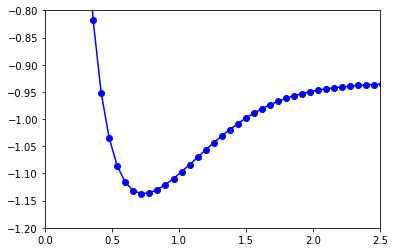

In [4]:
# OPENFERMION DATA ============================================================

# Bond lengths for which we have precomputed hamiltonians

with h5py.File("bond_lengths.hdf5", "r") as f:
    try:
        dset = f['bond_lengths']
        bond_lengths = np.zeros(dset.shape)
        dset.read_direct(bond_lengths)
    except KeyError:
        print("Subgroup 'bond_lengths' not in 'bond_lengths.hdf5' data")
        
if type(bond_lengths) == type(None):
    print("Could not read bond lengths.")
else:
    bond_lengths = np.round(bond_lengths, 2)
    
hamiltonians = []

for bond_length in bond_lengths:
    hamiltonian = None
    
    # read hamiltonian from appropriate file
    with h5py.File("hamiltonians/sto-3g.{}.hdf5".format(round(bond_length, 2)), 'r') as f:
        try:
            dset = f['hamiltonian']
            hamiltonian = dset[()]
        except KeyError:
            print("subgroup `hamiltonian` not in `hamiltonians/{}` data".format(bond_length))
    
    if type(hamiltonian) == type(None):
        print("Couldn't read hamiltonian for bond length {}".format(bond_length, 2))
        continue
    
    # add hamiltonian to dictionary of hamiltonians
    hamiltonians.append(Qobj(hamiltonian, dims=[[2,2,2,2],[2,2,2,2]]))
    
hamiltonians = np.array(hamiltonians)

def get_groundstate(hamiltonian):
    return hamiltonian.groundstate()

groundstatize = np.vectorize(get_groundstate)

# Compute groundstates of molecular hamiltonians to use as training and testing data
groundenergies, groundstates = groundstatize(hamiltonians)

# plot hydrogen atom bond-length vs. ground-state energies
# red points are those states selected for training, everything else is for testing
plt.plot(bond_lengths, groundenergies, 'ob-')
#plt.plot(bond_lengths[training_indices], groundenergies[training_indices], 'or')
plt.ylim([-1.2, -0.8])
plt.xlim([0, 2.5])